<a href="https://colab.research.google.com/github/Ravio1i/ki-lab/blob/master/2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Data

In [39]:
#@title Data parameters
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size =  4#@param {type:"integer"}
num_workers = 2#@param {type:"integer"}

#@tex Data
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualization

In [40]:
import matplotlib.pyplot as plt
import numpy as np

In [41]:
def imshow(img):
    img = img /2 + 0.5
    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

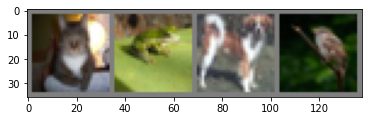

  cat  frog   dog  bird


In [42]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Convolutional Neural Network

In [43]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten for fully connected
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Hyper Parameters

In [56]:
learning_rate = 0.0001#@param {type:"number"}
momentum = 0.9#@param {type:"number"}
n_epochs = 2#@param {type:"integer"}
log_interval = 2000
PATH = './cifar_net.pth'#@param {type:"string"}


## Functions

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# Train

In [50]:
def train():
    print("""
    {}
    """
    )
    

    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % log_interval == 0:
                print('[%d, %5d] loss: %.3f' % (epoch +1, i +1, running_loss / log_interval))
                running_loss = 0.0

    print('Finished training')
    torch.save(net.state_dict(), PATH)

# Test

## Output

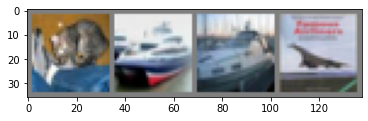

GroundTruth:    cat  ship  ship plane


In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Load back saved model

In [45]:
net = Net()
net.load_state_dict(torch.load(PATH))

NameError: ignored

Output on small size

In [36]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:    cat  ship  ship  ship


In [54]:
def test():
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            # Get correctly predicted labels
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

# Run

In [59]:
train()

[1,  2000] loss: 2.305
[1,  4000] loss: 2.305
[1,  6000] loss: 2.306
[1,  8000] loss: 2.306
[1, 10000] loss: 2.304
[1, 12000] loss: 2.308
[2,  2000] loss: 2.305
[2,  4000] loss: 2.304
[2,  6000] loss: 2.306
[2,  8000] loss: 2.307
[2, 10000] loss: 2.306
[2, 12000] loss: 2.305
Finished training
